In [17]:
import numpy as np
import math
import matplotlib.pyplot as plt
import time
import scipy as sp
import seaborn as sns
import pandas as pd

Initial memory usage: 269.4144 MB
========> 800 1 1.2499999999999998e-10 1e-07 25.600000000000005
8039
803


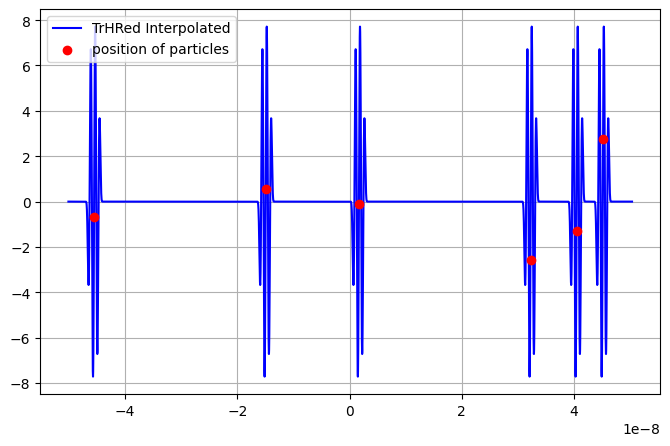

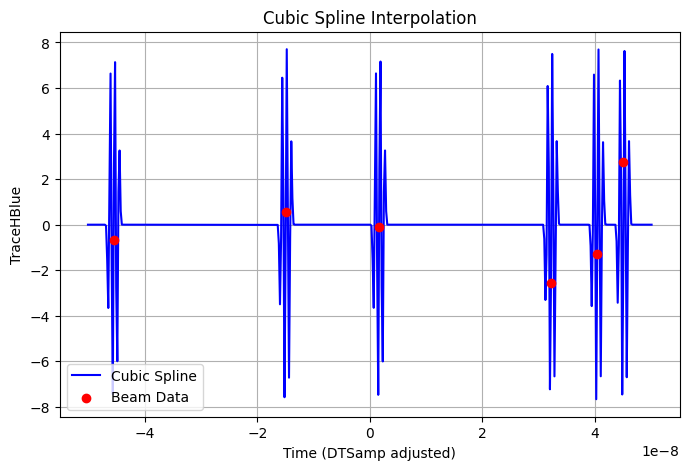

In [3]:
#we now will try to implement filter cooling....
#This will happen by keeping the signal one turn before and subtracting the current signal from it!
import numpy as np
import math
import matplotlib.pyplot as plt
import time
import scipy as sp
import seaborn as sns
import pandas as pd

import matplotlib.ticker as ticker
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import CubicSpline
import psutil
import os
import time

datin  = time.time()  # record start time - to estimate run duration at end
process = psutil.Process(os.getpid())

print(f"Initial memory usage: {process.memory_info().rss / 1e6} MB")



Nparts, Nturns =  15, 1
betPU, alfPU       =  1.3, -0.9
betK, alfK         =  0.8,  0.6
gamPU, gamK        =  (1 + alfPU**2)/betPU, (1 + alfK**2)/betK
muPUK, muKPU       =  1.51, 2*np.pi*1.34 - 1.51
total_angle        =  2*np.pi*1.34
etaPUK, etaKPU     =  0, -0.02    #eta PUK must be reletevely small, so they dont change slices so fast... 0.02 breaks the system ... It is the limit case!!!! very sensitive on etaPUK --> 2 much unwanted mixing, also etaKPU cant go very low(limit case 0.3) because then the mixing is bad
sigdelt            = .0001            # rms momentum spread in unit
Th, Trev           =  .1e-6, 5.0e-6, # half width of simulation window and revolution period in s
Tovlap, NSamp, add = 4*sigdelt*abs(etaPUK + etaKPU)*Trev, 800, '2000'
gain               =  0.00018  #as long as I reduce the eta, i have to reduce gains as well... see book
gainL              =  5e-7
over_sample_factor=10
#np.random.seed(54)

"""
wlH, wrH = -1.6e-9, 1.6e-9
def respH(Dt):
    if Dt < 1. * wlH or Dt > 1. * wrH:
        print(f' ===> function respH called with Dt ={1e6*Dt:8.4f}')
    return 0.5 * (1 + np.cos((2 * np.pi / wrH) * Dt))


"""
emittance_individual_particles = np.zeros((Nturns+2, 10))
# definition of the transverse "response function", which is given by the 
#    routine resp for the interval -wlH < Dt < wrH and 0 outside

""""
def time_function(func):
    #Decorator to measure the execution time of a function.
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        elapsed = end_time - start_time
        print(f"{func.__name__} executed in {elapsed:.6f} seconds.")
        return result
    return wrapper
"""

wlH, wrH = -1.6e-9, 1.6e-9
wlL, wrL = -1.6e-9, 1.6e-9

def respH( Dt ):
    #if Dt < 1.*wlH or Dt > 1.*wrH:
     #   print( f' ===> function respH called with Dt ={1e6*Dt:8.4f}' )
    return (1 - 27e18*Dt**2)*(1 - 3.e18*Dt**2)*(1 - 1.15e18*Dt**2)*(1 - (.625e9*Dt)**2)**7
#   return (1 - 23e16*Dt**2)*(1 - 3.e16*Dt**2)*(1 - 1.15e16*Dt**2)*(1 - (.625e8*Dt)**2)**7
#   return (1 - 25e-12*Dt^2)*(1 - 3e-12*Dt^2)*(1 - 1.15e-12*Dt^2)*(1 - (Dt/1.5)^2)^6


def respL( Dt ):
    #if Dt < 1.*wlL or Dt > 1.*wrL:
     #   print( f' ===> function respL called with Dt ={1e6*Dt:8.4f}' )
    return (63e9*Dt)*(1 - 6.5e18*Dt**2)*(1 - 1.55e18*Dt**2)*(1 - (.625e9*Dt)**2)**8

#rng = np.random.default_rng(18022005)


rng = np.random.default_rng(22754057649 )   #this gives us the random seed!!!!

# Total width (particles of both colors) of beam time window is 2*Th ('h' for half)
#  for sampling each sub-window (red or blue) divided into NSamp intervals. This
#  means samp,ing rate DTsamp and NSamp + 1 points. On both ends to be added 
#  ceiling( Tovlap/DTSamp ) points   
DTSamp   = Th/NSamp
NSampext = math.ceil( Tovlap/DTSamp )
inds = np.arange( (-NSampext)*over_sample_factor , (NSamp+1+NSampext + 1)*over_sample_factor )
t_bins = inds*DTSamp/over_sample_factor - Th/2 

print('========>', NSamp, NSampext, DTSamp, Th, (wrH - wlH)/DTSamp)

# Routine to do do the exchange of .. ended up by regrouping from scratch

#@time_function
def PartsExchange( ptsEarly, ptsLate ):
    ptsEarlyNew, ptsLateNew = [], []
    for x, xp, delt, Tau in ptsEarly:
        if Tau < Th/2:  # should remain in "early group
            ptsEarlyNew += [ [x, xp, delt, Tau] ]
        else:
            ptsLateNew += [ [x, xp, delt, Tau - Th] ]
    for x, xp, delt, Tau in ptsLate:
        if Tau > -Th/2:
            ptsLateNew += [ [x, xp, delt, Tau] ]
        else:
            ptsEarlyNew += [ [x, xp, delt, Tau + Th] ]
    return ptsEarlyNew, ptsLateNew

# Routine to generate time traces
#@time_function
def running_average(x, y, bins):
    """
    Compute the running average of y over fixed intervals in x efficiently using NumPy.

    Parameters:
    x (array-like): Array of x-values (sorted or unsorted).
    y (array-like): Array of y-values corresponding to x.
    interval_width (float): The width of the intervals.

    Returns:
    bin_centers (numpy.ndarray): The centers of the bins.
    averages (numpy.ndarray): The average y-values for each bin.
    """
    # Ensure inputs are NumPy arrays
    x = np.array(x)
    y = np.array(y)

    # Bin the data using NumPy digitize
    bin_indices = np.digitize(x, bins) - 1  # Get zero-based bin indices

    # keep only elements within bins
    valid_input_indices = (bin_indices > 0) & (bin_indices < len(bins) - 1)

    # Preallocate array for averages
    averages = np.zeros(len(bins) - 1, dtype=float)
    
    # Use NumPy's bincount for fast bin-based summation and counts
    bin_sums   = np.bincount(bin_indices[valid_input_indices], minlength=len(bins) - 1, weights=y[valid_input_indices])
    bin_counts = np.bincount(bin_indices[valid_input_indices], minlength=len(bins) - 1)
    
    # Avoid division by zero: compute averages where bin_counts > 0
    non_empty_bins = bin_counts > 0
    averages[non_empty_bins] = bin_sums[non_empty_bins] / bin_counts[non_empty_bins]

    # Compute bin centers
    bin_centers = (bins[:-1] + bins[1:]) / 2

    return bin_centers, averages, bin_counts, bin_sums


def TimeTraces2(ptsEarly, ptsMain, ptsLate, bins):
    """
    Generate time traces without applying the `Th / 2` offset internally.
    """
    
    ptsEarly = np.array(ptsEarly)
    ptsMain = np.array(ptsMain)
    ptsLate = np.array(ptsLate)
    # Compute histograms of beam distribution
    bin_centers_early, averages_early, count_early, sum_early = running_average(    
        ptsEarly[:, 3]-Th, ptsEarly[:, 0], bins    #here the previous slice, we put an offset of -Th (because it is -Th behind the current slice)
    )
    bin_centers_main, averages_main, count_main, sum_main = running_average(
        ptsMain[:, 3], ptsMain[:, 0], bins   #here the current slice, we dont put any offset        
    )
    bin_centers_late, averages_late, count_late, sum_late = running_average(
        ptsLate[:, 3]+Th, ptsLate[:, 0], bins   #here the next slice, we put an offset of +Th (because it is +Th ahead of the current slice)
    )

    # Compute time traces
    TraceH_early = np.convolve(respH_new_once, sum_early, 'same')
    TraceH_main = np.convolve(respH_new_once, sum_main, 'same')
    TraceH_late = np.convolve(respH_new_once, sum_late, 'same')
    
    TraceL_early = np.convolve(respL_new_once, count_early, 'same')
    TraceL_main = np.convolve(respL_new_once, count_main, 'same')
    TraceL_late = np.convolve(respL_new_once, count_late, 'same')

    TraceH = TraceH_early + TraceH_main + TraceH_late  #elementwise sum
    TraceL = TraceL_early + TraceL_main + TraceL_late
    
    #print(TraceH_early.shape, TraceH_main.shape, TraceH_late.shape, TraceH.shape)

    #bin_centers_main=bin_centers_early+bin_centers_main+bin_centers_late
    
    return bin_centers_main, TraceH, TraceL
   

def TimeTraces( ptsEarly, ptsMain, ptsLate ):
    TraceH = [ 0. for _ in range(NSamp + 1 + 2*NSampext) ]
    TraceL = [ 0. for _ in range(NSamp + 1 + 2*NSampext) ]
#   first generate transverse trace
    for x, xp, delt, Tau in ptsEarly:    #precious slice than the one under investigation
        for ind in range( max(-NSampext, math.ceil((wlH+Tau-Th+Th/2)/DTSamp)), 
                          min(NSamp+1+NSampext, math.ceil((wrH+Tau-Th+Th/2)/DTSamp)) ):
            TraceH[ind] += x*respH(ind*DTSamp -Th/2- (Tau-Th) )
    for x, xp, delt, Tau in ptsMain:     #slice under investigation
        for ind in range( max(-NSampext, math.ceil((wlH+Tau+Th/2)/DTSamp)), 
                          min(NSamp+1+NSampext, math.ceil((wrH+Tau+Th/2)/DTSamp)) ):
            TraceH[ind] += x*respH(ind*DTSamp-Th/2 - Tau )
    for x, xp, delt, Tau in ptsLate:       #next slice un h) )
        for ind in range( max(-NSampext, math.ceil((wlH+Tau+Th+Th/2)/DTSamp)), 
                          min(NSamp+1+NSampext, math.ceil((wrH+Tau+Th+Th/2)/DTSamp)) ):
            TraceH[ind] += x*respH(ind*DTSamp -Th/2- (Tau+Th) )
    for x, xp, delt, Tau in ptsEarly:
        for ind in range( max(-NSampext, math.ceil((wlL+Tau-Th+Th/2)/DTSamp)), 
                          min(NSamp+1+NSampext, math.ceil((wrL+Tau-Th+Th/2)/DTSamp)) ):
            TraceL[ind] += respL(ind*DTSamp -Th/2- (Tau-Th) )
    for x, xp, delt, Tau in ptsMain:
        for ind in range( max(-NSampext, math.ceil((wlL+Tau+Th/2)/DTSamp)), 
                          min(NSamp+1+NSampext, math.ceil((wrL+Tau+Th/2)/DTSamp)) ):
            TraceL[ind] += respL(ind*DTSamp -Th/2- Tau )
    for x, xp, delt, Tau in ptsLate:
        for ind in range( max(-NSampext, math.ceil((wlL+Tau+Th+Th/2)/DTSamp)), 
                          min(NSamp+1+NSampext, math.ceil((wrL+Tau+Th+Th/2)/DTSamp)) ):
            TraceL[ind] += respL(ind*DTSamp -Th/2- (Tau+Th) )
    return TraceH, TraceL



#@time_function
def kickH(pts, signalH):
    corrected_pts = []
    for x, xp, delt, Tau in pts:
        # Interpolate signalH at the particle's Tau
        signal_value = signalH(Tau)
        # Correct xp using the signal value (define your correction logic)
        corrected_xp = xp +gain * signal_value  # I add the signal!!!!!
        # Append the updated particle to the new list
        corrected_pts.append([x, corrected_xp, delt, Tau])
    return corrected_pts
#@time_function
def kickL(pts, signalL):
    corrected_pts = []
    for x, xp, delt, Tau in pts:
        # Interpolate signalL at the particle's Tau
        signal_value = signalL(Tau)
        # Correct xp using the signal value (define your correction logic)
        corrected_delt = delt + gainL * signal_value  # Example: subtracting scaled signal
        # Append the updated particle to the new list
        corrected_pts.append([x, xp, corrected_delt, Tau])
    return corrected_pts
#@time_function
def compute_cubic_spline(DTSamp, NSampext, NSamp, Th, TrHBlue):
     x = DTSamp * np.arange(-NSampext, NSamp + 1 + NSampext) - Th / 2
     y = np.concatenate((TrHBlue[-NSampext:], TrHBlue[:NSamp + 1 + NSampext]))
    
    #if len(x) != len(y):
     #   raise ValueError(f"The length of `y` ({len(y)}) doesn't match the length of `x` ({len(x)})")
    
     return CubicSpline(x, y)



respH_new_once = respH(np.arange(wlH, wrH, DTSamp/over_sample_factor ))
respL_new_once = respL(np.arange(wlL, wrL, DTSamp/over_sample_factor ))

# Computation of transverse transfer matrix elements
projPU11 =  betPU**(1/2)
projPU21 = -alfPU/betPU**(1/2)
projPU22 =  1/betPU**(1/2)

matPUK11 = ((betK/betPU)**(1/2))*(np.cos(muPUK) + alfPU*np.sin(muPUK))
matPUK12 = ((betPU*betK)**(1/2))*np.sin(muPUK)
matPUK21 = ((alfPU-alfK)*np.cos(muPUK) - (1+alfPU*alfK)*np.sin(muPUK))/((betPU*betK)**(1/2))
matPUK22 = ((betPU/betK)**(1/2))*(np.cos(muPUK) - alfK*np.sin(muPUK))

matKPU11 = ((betPU/betK)**(1/2))*(np.cos(muKPU) + alfK*np.sin(muKPU))
matKPU12 = ((betPU*betK)**(1/2))*np.sin(muKPU)
matKPU21 = ((alfK-alfPU)*np.cos(muKPU) - (1+alfPU*alfK)*np.sin(muKPU))/((betPU*betK)**(1/2))
matKPU22 = ((betK/betPU)**(1/2))*(np.cos(muKPU) - alfPU*np.sin(muKPU))

# Generate macroparticles in two groups with red ones and blue ones
#    .. say we start with red particles the early ones
ptsRed  = []
ptsBlue = []
for _ in range(Nparts):
    Tau = rng.uniform(-Th, Th)
    xn, xpn, deltn = rng.normal(0., 1.), rng.normal(0., 1.), rng.normal(0., 1.)
    if Tau < 0: 
        ptsRed += [ [projPU11*xn, projPU21*xn + projPU22*xpn, 
                     deltn*sigdelt, Tau + Th/2] ]
    else:
        ptsBlue += [ [projPU11*xn, projPU21*xn + projPU22*xpn, 
                      deltn*sigdelt, Tau - Th/2] ]


emittance=np.zeros(Nturns+2)
geo_emittance=np.zeros(Nturns+2)
beam=[]
xp_beam=[]
x_beam=[]
beam=ptsRed+ptsBlue
beam = np.array(beam)
x_beam=beam[:,0]
xp_beam=beam[:,1]
x_initial=x_beam
xp_initial=xp_beam
tau_initial=beam[:,3]
delt_initial=beam[:,2]
emittance[0]=np.sqrt(np.mean(x_initial**2)*np.mean(xp_initial**2)-np.mean(x_initial*xp_initial)**2)   
geo_emittance[0]=((gamPU*np.mean(x_initial**2)+2*alfPU*np.mean(x_initial*xp_initial)+betPU*np.mean(xp_initial**2)))/2
emittance_individual_particles[0][:]=(gamPU*x_beam[:10]**2+2*alfPU*(x_beam[:10]*xp_beam[:10])+betPU*(xp_beam[:10]**2))/2



# Track red (now early) particles ones once around
ptsRedprev = ptsRed
ptsRed = [ [matPUK11*x + matPUK12*xp, matPUK21*x + matPUK22*xp, delt, 
            Tau + etaPUK*delt*Trev] for x, xp, delt, Tau in ptsRed ]  # no action at kicker
ptsRed = [ [matKPU11*x + matKPU12*xp, matKPU21*x + matKPU22*xp, delt, 
            Tau + etaKPU*delt*Trev] for x, xp, delt, Tau in ptsRed]

# Prepare for tracking of blue particles and track them once around
ptsBlue, ptsRed = PartsExchange( ptsBlue, ptsRed )
ptsBlueprev = ptsBlue
TrHBlue, TrLBlue = TimeTraces( ptsRedprev, ptsBlue, ptsRed )
time2,TrHBlue2, TrLBlue2 = TimeTraces2( ptsRedprev, ptsBlue, ptsRed,t_bins )
new_2_t_time_trace =  time2 
cs = compute_cubic_spline(DTSamp, NSampext, NSamp, Th, TrLBlue)
cs2=sp.interpolate.CubicSpline( time2, 
                  np.array(TrLBlue2) )
print(len(time2))
print(NSamp + 1 + 2*NSampext)
#t_smooth=new_2_t_time_trace-Th-Tovlap-DTSamp
y_cs = cs2(time2)
x_vals = np.linspace(-Th/2 - NSampext * DTSamp, (NSamp + NSampext) * DTSamp - Th/2, 500)
y_vals = cs(x_vals)

tauPU=[]
xPU=[]
beam=ptsBlue
beam = np.array(beam)
tauPU=beam[:,3]
xPU=beam[:,0]

plt.figure(figsize=(8, 5))
plt.plot(time2, y_cs, label="TrHRed Interpolated", color='blue')
#plt.plot(t_smooth, y_csL, label="TrLDiffRed Interpolated", linestyle="--")
#plt.scatter(time2, TrHBlue2, marker="o", color="blue", label="horizontal signal")
plt.scatter(tauPU, xPU, zorder=5, color="red", label="position of particles")
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(8, 5))
plt.plot(x_vals, y_vals, label='Cubic Spline', color='blue')
    #plt.scatter(cs.x, cs(cs.x), color='red', label='Data Points', zorder=5)  # Interpolated points
plt.scatter(tauPU,xPU, color='red', label='Beam Data', zorder=5)  # Use scatter for point data
plt.title('Cubic Spline Interpolation')
plt.xlabel('Time (DTSamp adjusted)')
plt.ylabel('TraceHBlue')
plt.legend()
plt.grid(True)
plt.show()
















ptsBlue = [ [matPUK11*x + matPUK12*xp, matPUK21*x + matPUK22*xp, delt, 
            Tau + etaPUK*delt*Trev] for x, xp, delt, Tau in ptsBlue ]  # no action at kicker
#ptsBlue=kickH(ptsBlue,cs)
ptsBlue = [ [matKPU11*x + matKPU12*xp, matKPU21*x + matKPU22*xp, delt, 
            Tau + etaKPU*delt*Trev] for x, xp, delt, Tau in ptsBlue]

TrHBlue_prev, TrLBlue_prev = TrHBlue, TrLBlue

# Prepare for 2nd tracking of red particles and track them once around
ptsRed, ptsBlue = PartsExchange( ptsRed, ptsBlue )
ptsRedprev = ptsRed
TrHRed, TrLRed = TimeTraces( ptsBlueprev, ptsRed, ptsBlue )
#cs = sp.interpolate.CubicSpline( DTSamp*np.arange(-NSampext, NSamp + 1 + NSampext)-Th/2, 
 #                 TrHRed[-NSampext:] + TrHRed[:NSamp + 1 + NSampext] )
ptsRed = [ [matPUK11*x + matPUK12*xp, matPUK21*x + matPUK22*xp, delt, 
            Tau + etaPUK*delt*Trev] for x, xp, delt, Tau in ptsRed ]  # no action at kicker
#ptsRed=kickH(ptsRed,cs)
ptsRed = [ [matKPU11*x + matKPU12*xp, matKPU21*x + matKPU22*xp, delt, 
            Tau + etaKPU*delt*Trev] for x, xp, delt, Tau in ptsRed]


TrHRed_prev, TrLRed_prev = TrHRed, TrLRed
# Now the blue ones are early - now just enter loop over number of turns
#   later - for longitudinal filter cooling - some more tracking will be needed

beam=[]
xp_beam=[]
x_beam=[]
beam=ptsRed+ptsBlue
beam = np.array(beam)
x_beam=beam[:,0]
xp_beam=beam[:,1]
emittance[1]=np.sqrt(np.mean(x_beam**2)*np.mean(xp_beam**2)-np.mean(x_beam*xp_beam)**2) 
emittance_individual_particles[1][:]=(gamPU*x_beam[:10]**2+2*alfPU*(x_beam[:10]*xp_beam[:10])+betPU*(xp_beam[:10]**2))/2
rms_momentum_spread=np.zeros(Nturns)

# Now we can go in loop and even implement transverse cooling or longitudinal time delay cooling (but not filter)
for turn in range(Nturns):
    #print(f' turn {turn:5d} after {(time.time() - datin):8.2f} s <===')
#   Get ready for the blue particles to be tracked and track them to kicker
    ptsBlue, ptsRed = PartsExchange( ptsBlue, ptsRed )
    ptsBlueprev, TrLBlueprev = ptsBlue, TrLBlue  # Keep longitudinal trace to add filter cooling later
    TrHBlue, TrLBlue = TimeTraces( ptsRedprev, ptsBlue, ptsRed )
    #TrHDiffBlue = [h - l for h, l in zip(TrHBlue_prev, TrHBlue)]
    TrLDiffBlue = [h - l for h, l in zip(TrLBlue_prev, TrLBlue)]
    #if len(TrLDiffRed)!= len(TrLBlue_prev) or len(TrLDiffRed)!= len(TrLBlue):
     #   print(f"ERROR")
    #TrLDiffBlue=np.array(TrLBlue_prev)-np.array(TrLBlue)
   
    cs = compute_cubic_spline(DTSamp, NSampext, NSamp, Th, TrHBlue)

    csL=compute_cubic_spline(DTSamp, NSampext, NSamp, Th, TrLDiffBlue)
    #cs = sp.interpolate.interp1d( DTSamp*np.arange(-NSampext, NSamp + 1 + NSampext)-Th/2, 
     #             TrHBlue[-NSampext:] + TrHBlue[:NSamp + 1 + NSampext] )
    #csL=sp.interpolate.interp1d( DTSamp*np.arange(-NSampext, NSamp + 1 + NSampext)-Th/2, 
     #             TrLBlue[-NSampext:] + TrLBlue[:NSamp + 1 + NSampext] )

    #print(len(TrHBlue))
    ptsBlue = [ [matPUK11*x + matPUK12*xp, matPUK21*x + matPUK22*xp, delt, 
                 Tau + etaPUK*delt*Trev] for x, xp, delt, Tau in ptsBlue ]
#   One day cooling to be applied -  now just dump time traces instead
    ptsBlue=kickH(ptsBlue,cs)
    ptsBlue=kickL(ptsBlue,csL)
#   track the blue one further to the PU
    ptsBlue = [ [matKPU11*x + matKPU12*xp, matKPU21*x + matKPU22*xp, delt, 
                 Tau + etaKPU*delt*Trev] for x, xp, delt, Tau in ptsBlue ]
    
    TrHBlue_prev, TrLBlue_prev = TrHBlue, TrLBlue
#   Get ready for the red particles to be tracked and track them to kicker
    ptsRed, ptsBlue = PartsExchange( ptsRed, ptsBlue )
    ptsRedprev, TrLRedprev = ptsRed, TrLRed  # Keep longitudinal trace to add filter cooling later
    TrHRed, TrLRed = TimeTraces( ptsBlueprev, ptsRed, ptsBlue )
    #TrHDiffRed= [h - l for h, l in zip(TrHRed_prev, TrHRed)]
    TrLDiffRed = [h - l for h, l in zip(TrLRed_prev, TrLRed)]
    #TrLDiffRed=np.array(TrLRed_prev)-np.array(TrLRed)
    
    cs= compute_cubic_spline(DTSamp, NSampext, NSamp, Th, TrHRed)
    csL=compute_cubic_spline(DTSamp, NSampext, NSamp, Th, TrLDiffRed)
    x_vals = np.linspace(-Th/2 - NSampext * DTSamp, (NSamp + NSampext) * DTSamp - Th/2, 500)
    y_vals = cs(x_vals)
    #print("Spline Knots:", cs.x)  # Knots where the spline pieces join
    #print("Spline Coefficients:", cs.c)  # Coefficients of the spline pieces
   
    tauPU=[]
    xPU=[]
    beam=ptsRed
    beam = np.array(beam)
    tauPU=beam[:,3]
    xPU=beam[:,0]
    
# 

     
    ptsRed = [ [matPUK11*x + matPUK12*xp, matPUK21*x + matPUK22*xp, delt, 
                Tau + etaPUK*delt*Trev] for x, xp, delt, Tau in ptsRed ]
#   One day cooling(s) to be applied - now just dump time traces instead
    ptsRed=kickH(ptsRed,cs)
    ptsRed=kickL(ptsRed,csL)   #time of flight method longitudinal cooling
#   track the red ones further to the PU, where they will be the late ones
    ptsRed = [ [matKPU11*x + matKPU12*xp, matKPU21*x + matKPU22*xp, delt, 
                Tau + etaKPU*delt*Trev] for x, xp, delt, Tau in ptsRed ] 
    
    TrHRed_prev, TrLRed_prev = TrHRed, TrLRed


    beam=[]
    xp_beam=[]
    x_beam=[]
    delta_beam=[]
    dlt_final=[]
    tau_final=[]
    beam=ptsRed+ptsBlue
    beam = np.array(beam)
    x_beam=beam[:,0]
    xp_beam=beam[:,1]
    delta_beam=beam[:,2]
    tau_final=beam[:,3]
    dlt_final=beam[:,2]
    emittance[turn+2]=np.sqrt(np.mean(x_beam**2)*np.mean(xp_beam**2)-np.mean(x_beam*xp_beam)**2)
    geo_emittance[turn+2]=(gamPU*np.mean(x_beam**2)+2*alfPU*np.mean(x_beam*xp_beam)+betPU*np.mean(xp_beam**2))/2
    rms_momentum_spread[turn]=np.sqrt(np.mean(delta_beam**2)-np.mean(delta_beam)**2)
    #emittance_individual_particles[turn+2][:]=(gamPU*x_beam[:10]**2+2*alfPU*(x_beam[:10]*xp_beam[:10])+betPU*(xp_beam[:10]**2))/2
